# MHKiT Tidal Module

The following example will familiarize the user with the [MHKiT tidal module](https://mhkit-software.github.io/MHKiT/mhkit-python/api.tidal.html) by stepping through the calculation of the velocity duration curve. The data file used in this example is stored in the [\\\\MHKiT\\\\examples\\\\data](https://github.com/MHKiT-Software/MHKiT-Python/tree/master/examples/data) directory.

Start by importing the necessary MHKiT module.

In [1]:
from mhkit import tidal

## Loading Data from NOAA-Currents
   
This example uses 1 year of data from the NOAA-Currents sites. A map of available currents stations is available at https://tidesandcurrents.noaa.gov/map/. The tidal io module includes two functions to import data: `request_noaa_data` which pulls data from the website, and `read_noaa_json` which loads a JSON file.  The request function can save the JSON file for later use.  

For simplicity, this example loads data from a JSON file into a pandas DataFrame.  This data contains 1 year of 6 minute averaged data from the Southampton Shoal Channel LB 6 (Station Number: s08010) in San Francisco Bay. The data includes 6 minute averaged direction [degrees] and speed [cm/s] indexed by time. The DataFrame key names returned by NOAA are 'd' for direction and 's' for speed. Since MHKIT uses SI units, speed is converted to m/s. 

In [2]:
# Load tidal data, South Hampton Shoal LB 6
data, metadata = tidal.io.read_noaa_json('data/tidal/s08010.json')

# Convert discharge data from cm/s to m/s
data.s = data.s / 100

# Print data
print(data)

                         s    d  b
2016-11-08 12:04:00  0.673  358  4
2016-11-08 12:34:00  0.689  360  4
2016-11-08 12:46:00  0.738  356  4
2016-11-08 12:58:00  0.744  359  4
2016-11-08 13:10:00  0.648  358  4
...                    ...  ... ..
2018-04-01 22:02:00  0.089  296  4
2018-04-01 22:14:00  0.102  356  4
2018-04-01 22:26:00  0.011    3  4
2018-04-01 22:38:00  0.060  193  4
2018-04-01 23:20:00  0.439  165  4

[18890 rows x 3 columns]


The data can also be obtained using the function `request_noaa_data` in the tidal IO module. 
To use this function, we need a station number, parameter type, start date, and end date.
The station number can be found on the NOAA tides and currents website linked above. 
The IEC standard recommends 1 year of 10-minute direction and velocity data. The request function allows users to easily pull any timeframe of data although NOAA limits any one pull to 30 days.

The following code, which has been commented out for this demonstration, can be used to pull data from the NOAA website. This function can be used to save data to a JSON for later use.

In [3]:
#data, metadata = tidal.io.request_noaa_data(station='s08010', parameter='currents',
#                               start_date='20161101', end_date='20180401',
#                               proxy=None, write_json=`data/s08010.json`)

## Principal Flow Directions
As an initial check on the data, a velocity plot can be created to identify data gaps. To consider the velocity in one of the principal flow directions we apply the `principal_flow_directions` function. This function returns 2 directions (in degrees) corresponding to the flood and ebb directions of the tidal site.  Principal flow directions are calculated based on the highest frequency directions. These directions are often close to 180 degrees apart but are not required to be.

The `plot_current_timeseries` function plots velocity in either direction using the speed timeseries. 

In [4]:
# Specify histogram bin width for directions to calculate the principal flow directions 
width_direction = 1   # in degrees

# Compute two principal flow directions
direction1, direction2 = tidal.resource.principal_flow_directions(data.d, width_direction)

# Set flood and ebb directions based on site knowledge
flood = direction1 # Flow into 
ebb = direction2 # Flow out 

The time series of current data can be plotted using the `plot_current_timeseries` function, which can include either the flood or ebb directions.

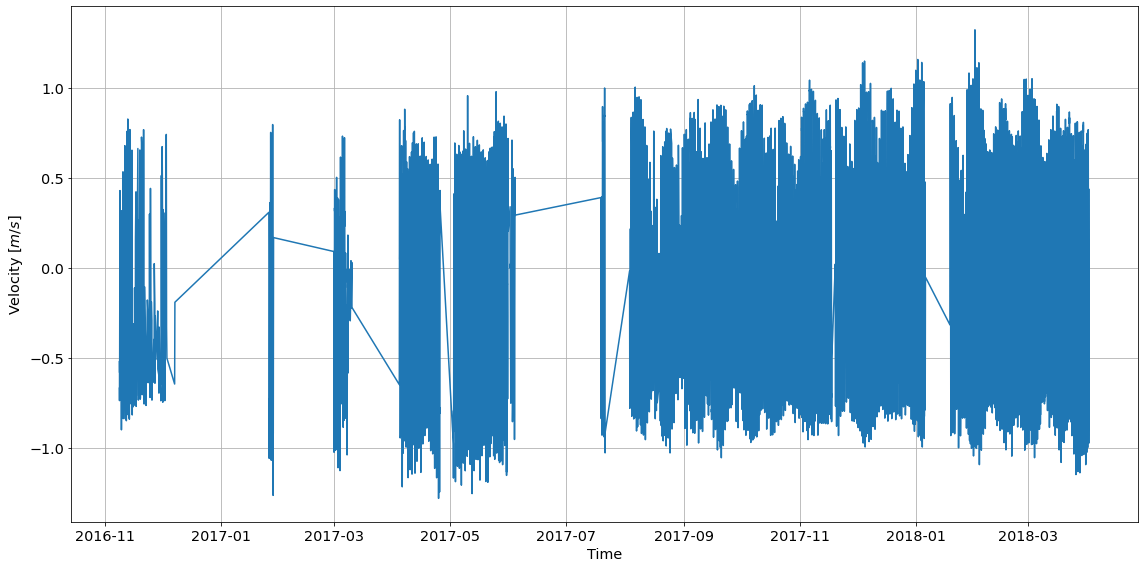

In [5]:
ax = tidal.graphics.plot_current_timeseries(data.d, data.s, flood)

The plot above shows missing data for most of early and mid-2017. The IEC standard recommends a minimum of 1 year of 10 minute averaged data (See IEC 201 for full description). For the demonstration, this dataset is sufficient. To look at a specific month we can slice the dataset before passing to the plotting function.

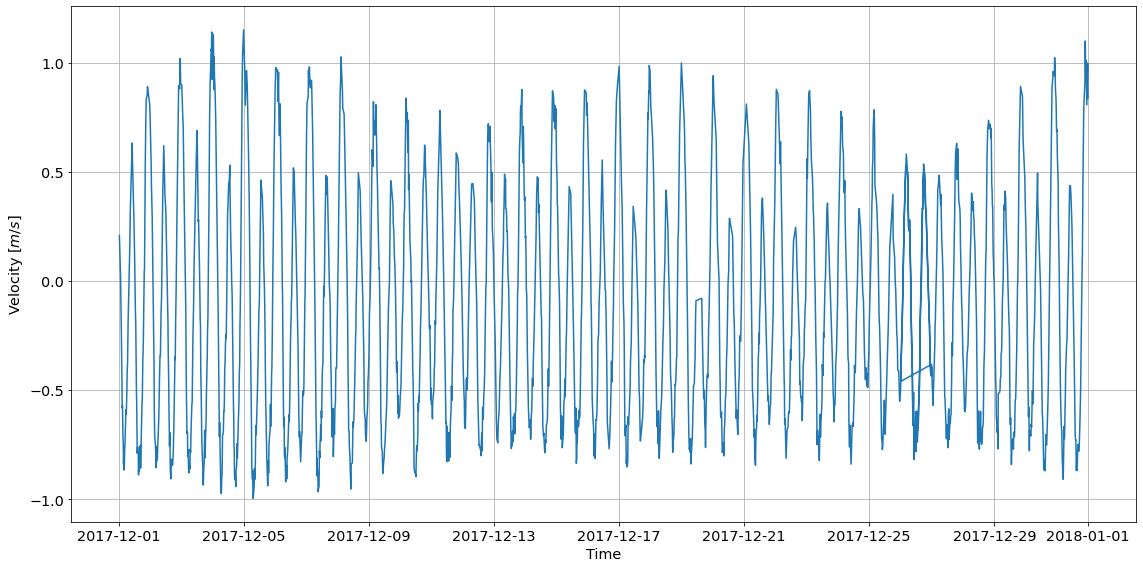

In [6]:
# Slice December of 2017 out of the full dataset
dec17_data = data.loc['2017-12-01':'2017-12-31']

# Plot December of 2017 as current timeseries
ax = tidal.graphics.plot_current_timeseries(dec17_data.d, dec17_data.s, flood)

## Joint Probability Distribution

Direction and velocity can be viewed as a joint probability distribution on a polar plot. This plot helps visually show the flood and ebb directions and the frequency of particular directional velocities. 

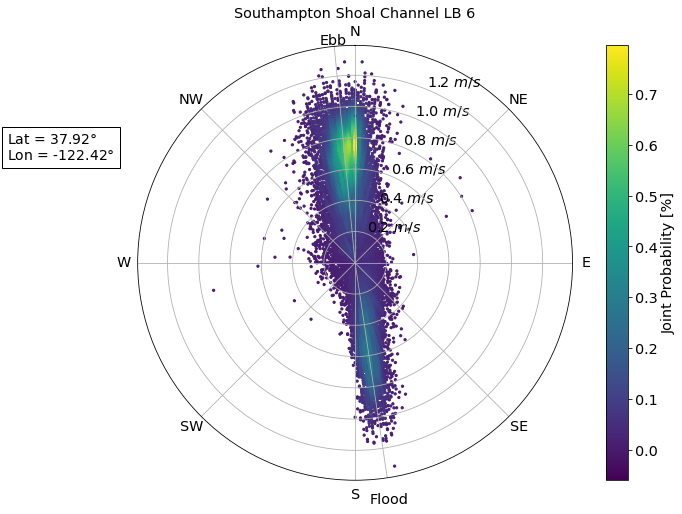

In [7]:
# Set the joint probability bin widths
width_direction = 1   # in degrees
width_velocity  = 0.1 # in m/s

# Plot the joint probability distribution
ax = tidal.graphics.plot_joint_probability_distribution(data.d, data.s, \
        width_direction, width_velocity, metadata=metadata, flood=flood, ebb=ebb)

## Rose plot

A rose plot shows the same information as the joint probability distribution but the probability is now the r-axis, and the velocity is the contour value. As compared to a joint probability distribution plot, a rose plot can be more readable when using larger bins sizes.

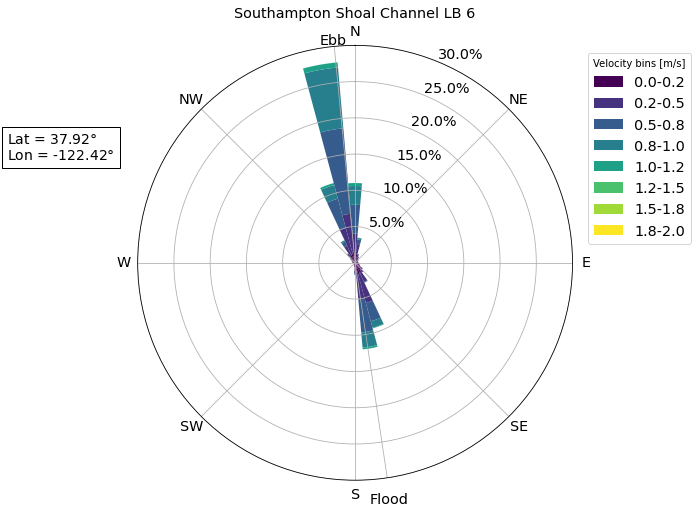

In [8]:
# Define bin sizes
width_direction = 10   # in degrees
width_velocity  = 0.25 # in m/s

# Create a rose plot
ax = tidal.graphics.plot_rose(data.d, data.s, width_direction, \
          width_velocity, metadata=metadata, flood=flood, ebb=ebb)

## Velocity Duration Curve

The velocity duration curve shows the probability of achieving a particular velocity value. After computing the exceedance probability, the rank order of velocity values can be plotted as follows.

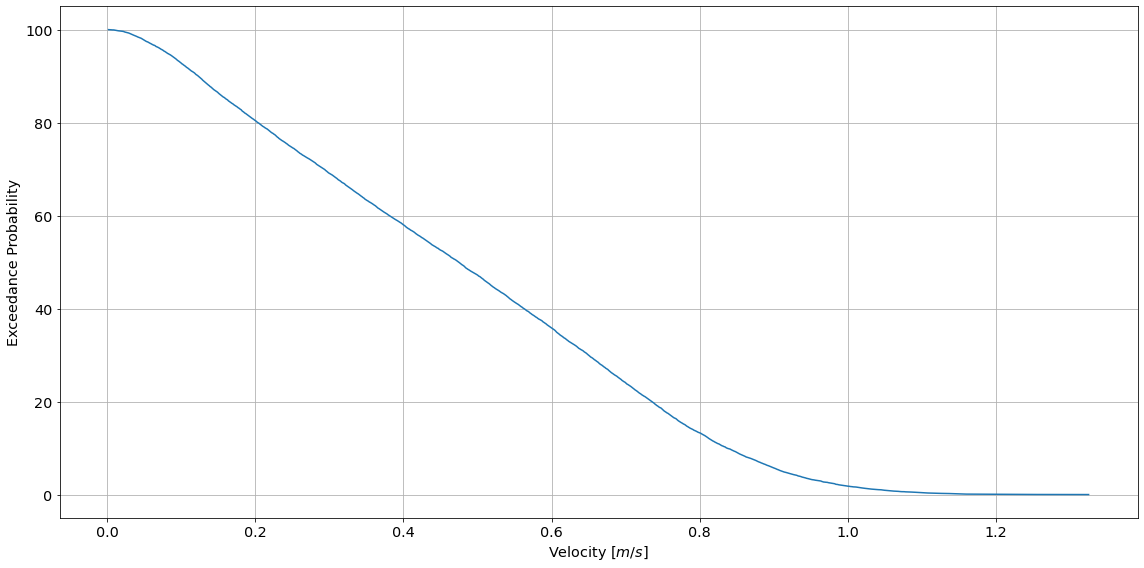

In [9]:
# Calculate exceedance probability of data
data['F'] = tidal.resource.exceedance_probability(data.s)

# Plot the velocity duration curve (VDC)
ax = tidal.graphics.plot_velocity_duration_curve(data.s, data.F)